In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter


import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import array as ar
import json
import pprint

import pandas as pd
from pandas import json_normalize

from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

torch.backends.mps.is_built()

True

In [19]:
# Function: Scale data and save scaler
def scaledata(X_train,X_test):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(X_train)
    normalized = scaler.transform(X_train)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    return X_train, X_test, scaler

In [20]:
# Function: reset RNN weights 
def init_weights(self):

    # Apply xavier initialization for hidden2hidden and input2hidden weights
#     torch.nn.init.xavier_uniform_(self.fc1.weight,gain=0.1)
#     torch.nn.init.xavier_uniform_(self.fc2.weight,gain=0.1)
    
    torch.nn.init.xavier_uniform_(self.output.weight,gain=1)
    torch.nn.init.xavier_uniform_(self.hidden.weight,gain=1)
    
#     torch.nn.init.xavier_uniform_(self.output.weight,gain=0.1)
#     torch.nn.init.xavier_uniform_(self.layer1.weight,gain=0.1)
#     torch.nn.init.xavier_uniform_(self.layer2.weight,gain=0.1)
#     torch.nn.init.xavier_uniform_(self.layer3.weight,gain=0.1)
    

In [21]:
#Import txt files and combine into single panda dataframe ()

# define filenames
years = ['2023','2022','2021','2020','2019','2018','2017','2016','2015','2014','2013','2012']

# reading the data from the file
for i in range(len(years)):
    filename = 'data/draft_' + years[i] + '.txt'
    with open(filename) as f:
        data = f.read()
        js = json.loads(data)
        df = json_normalize(js['players']) 
        num_row = df.shape[0]
        year_column = [years[i] for x in range(num_row)]
        df.insert(0, "year", year_column, True)
        
    if i==0:
        df_combined = df
    else:
        df_combined = pd.concat([df_combined, df], ignore_index=True)
        
df_combined['adp_diff'] = 100
df_combined['boom_bust'] = 3
df_combined['seasons_played'] = 0
print(df_combined)

      year  player_id                 name position team    adp adp_formatted  \
0     2023       4876     Justin Jefferson       WR  MIN    1.4          1.01   
1     2023       2434  Christian McCaffrey       RB   SF    2.1          1.02   
2     2023       5177        Ja'Marr Chase       WR  CIN    2.8          1.03   
3     2023       2390          Tyreek Hill       WR  MIA    4.4          1.04   
4     2023       2449          Cooper Kupp       WR  LAR    5.6          1.06   
...    ...        ...                  ...      ...  ...    ...           ...   
2210  2012       1666         Josh Freeman       QB   TB  141.1         15.01   
2211  2012       1814          Greg Little       WR  CLE  145.0         15.05   
2212  2012        189          Brent Celek       TE  PHI  152.0         16.02   
2213  2012       1822         Shane Vereen       RB   NE  152.8         16.03   
2214  2012       1303      Buffalo Defense      DEF  BUF  156.9         16.07   

      times_drafted  high  

In [22]:
# Change strings to one-hot-encoded variables
# Variable: Team, position 

cat_vars = ['team']
for var in cat_vars:
    catList = 'var'+'_'+var
    catList = pd.get_dummies(df_combined[var], prefix=var)
    data1 = df_combined.join(catList.astype(int))
    df_combined = data1
    
cat_vars = ['position']
for var in cat_vars:
    catList = 'var'+'_'+var
    catList = pd.get_dummies(df_combined[var], prefix=var)
    data1 = df_combined.join(catList.astype(int))
    df_combined = data1
    
print(df_combined)


      year  player_id                 name position team    adp adp_formatted  \
0     2023       4876     Justin Jefferson       WR  MIN    1.4          1.01   
1     2023       2434  Christian McCaffrey       RB   SF    2.1          1.02   
2     2023       5177        Ja'Marr Chase       WR  CIN    2.8          1.03   
3     2023       2390          Tyreek Hill       WR  MIA    4.4          1.04   
4     2023       2449          Cooper Kupp       WR  LAR    5.6          1.06   
...    ...        ...                  ...      ...  ...    ...           ...   
2210  2012       1666         Josh Freeman       QB   TB  141.1         15.01   
2211  2012       1814          Greg Little       WR  CLE  145.0         15.05   
2212  2012        189          Brent Celek       TE  PHI  152.0         16.02   
2213  2012       1822         Shane Vereen       RB   NE  152.8         16.03   
2214  2012       1303      Buffalo Defense      DEF  BUF  156.9         16.07   

      times_drafted  high  

In [23]:
# Create labels for each person where they were a boom or bust from the year before

# Boom criteria: current ADP > previous ADP
    # doesn't work without previous year ADP
    
# Find player id
player_id = pd.unique(df_combined['player_id'])
df_combined["year"] = pd.to_numeric(df_combined["year"])
df_combined_hold = df_combined #this is to save current year data

print(player_id[0])

#cycle through player IDs
for i in range(len(player_id)):

    player = df_combined.loc[df_combined['player_id'] == player_id[i]]
    player = player.sort_values(by=['year'],ascending=False)
    row_number = player.index
    num_years = row_number.shape
#     print(row_number[0])
    if num_years[0] == 1: # If only one year then mark row for removal
        df_combined.at[row_number[0], 'boom_bust'] = 2 # rows with 2s are the ones that will be removed later

    if num_years[0] > 1:     
        for j in range(num_years[0]-1):
            if j == 0:
                #mark most recent year for removal since no future year to compare against
                df_combined.at[row_number[j],'boom_bust'] = 2

            # take difference in adp spot from one year to the previous year
            adp_diff = df_combined.at[row_number[j+1],'adp'] - df_combined.at[row_number[j],'adp']
            # apply adp diff to data fram
            df_combined.at[row_number[j+1],'adp_diff'] = adp_diff

            if adp_diff > 0:
                # If difference is positive mark row as boom (boom=1)
                df_combined.at[row_number[j+1],'boom_bust'] = 1

            else:
                # If difference is negative mark row as bust (bust=0)
                df_combined.at[row_number[j+1],'boom_bust'] = 0
                
            df_combined.at[row_number[j+1],'seasons_played'] = j

#Make a data frame with just our current year to generate predictions with
df_2023_all = df_combined[df_combined.year == 2023]
df_2022_all = df_combined[df_combined.year == 2022]
                        
# remove current year from dataframe                 
df_combined = df_combined[df_combined.year != 2023]  
df_combined = df_combined[df_combined.boom_bust != 2]
df_combined = df_combined[df_combined.position != 'PK']
df_combined = df_combined[df_combined.position != 'DEF'] 
# df_combined = df_combined[df_combined.position != 'WR'] 
# df_combined = df_combined[df_combined.position != 'QB'] 
# df_combined = df_combined[df_combined.position != 'TE'] 

df_2023_all = df_2023_all[df_2023_all.position != 'PK']
df_2023_all = df_2023_all[df_2023_all.position != 'DEF']
# df_2023_all = df_2023_all[df_2023_all.position != 'WR'] 
# df_2023_all = df_2023_all[df_2023_all.position != 'QB'] 
# df_2023_all = df_2023_all[df_2023_all.position != 'TE'] 

df_2022_all = df_2022_all[df_2022_all.position != 'PK']
df_2022_all = df_2022_all[df_2022_all.position != 'DEF']
# df_2022_all = df_2022_all[df_2022_all.position != 'WR'] 
# df_2022_all = df_2022_all[df_2022_all.position != 'QB'] 
# df_2022_all = df_2022_all[df_2022_all.position != 'TE'] 

# remove columns with character values
df_NN = df_combined.drop(columns=['name', 'player_id','team','position','adp','adp_diff',
                                  'adp_formatted','high','low','times_drafted','stdev'])
df_2023 = df_2023_all.drop(columns=['name', 'player_id','team','position','adp','adp_diff',
                                    'adp_formatted','high','low','times_drafted','stdev'])
df_2022 = df_2022_all.drop(columns=['name', 'player_id','team','position','adp','adp_diff',
                                    'adp_formatted','high','low','times_drafted','stdev'])

my_list = list(df_NN)
print(my_list)

#Show all years to debug target creation
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(df_combined[['year', 'boom_bust']])
    


4876
['year', 'bye', 'boom_bust', 'seasons_played', 'team_ARI', 'team_ATL', 'team_BAL', 'team_BUF', 'team_CAR', 'team_CHI', 'team_CIN', 'team_CLE', 'team_DAL', 'team_DEN', 'team_DET', 'team_FA', 'team_GB', 'team_HOU', 'team_IND', 'team_JAX', 'team_KC', 'team_LAC', 'team_LAR', 'team_LV', 'team_MIA', 'team_MIN', 'team_NE', 'team_NO', 'team_NYG', 'team_NYJ', 'team_PHI', 'team_PIT', 'team_SEA', 'team_SF', 'team_TB', 'team_TEN', 'team_WAS', 'position_DEF', 'position_PK', 'position_QB', 'position_RB', 'position_TE', 'position_WR']


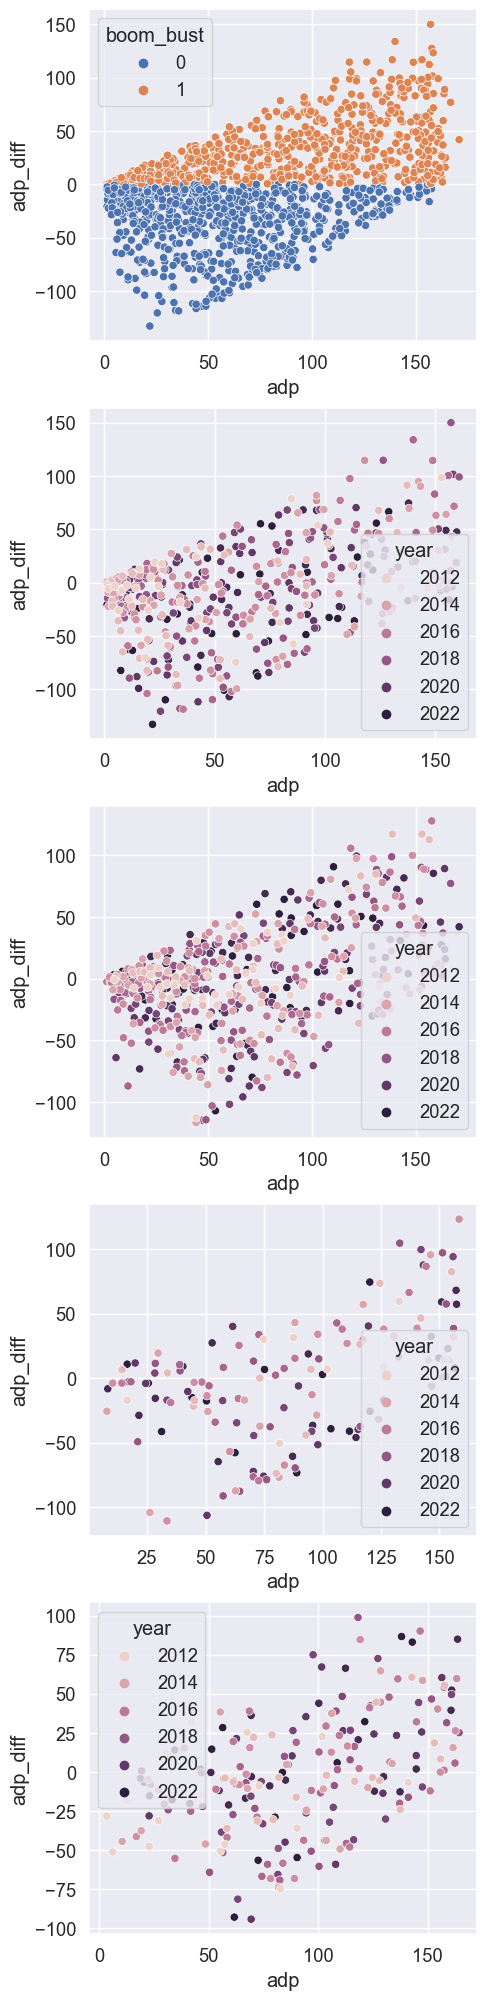

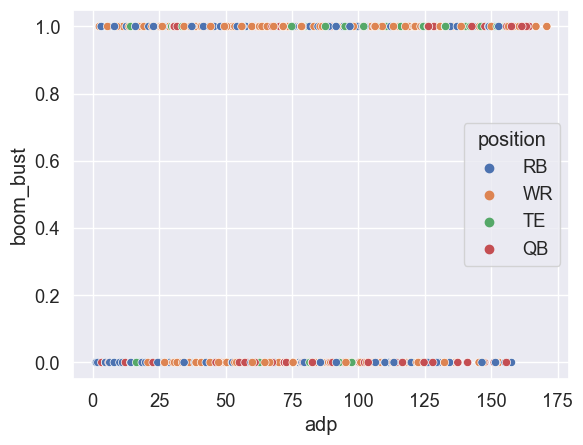

In [24]:
# Plot data for funsies

#Make data frames for individual positions
df_combined_rb = df_combined[df_combined.position == 'RB'] 
df_combined_wr = df_combined[df_combined.position == 'WR']
df_combined_te = df_combined[df_combined.position == 'TE']
df_combined_qb = df_combined[df_combined.position == 'QB']

# x: current adp
# y: next year adp

# Create scatter plot
# df_combined.plot.scatter(x='adp', y='adp_diff')
figs, axes = plt.subplots(5,1,figsize=(5, 25))
sns.scatterplot(ax=axes[0],data=df_combined, x='adp', y='adp_diff', hue='boom_bust')
sns.scatterplot(ax=axes[1],data=df_combined_rb, x='adp', y='adp_diff', hue = 'year')
sns.scatterplot(ax=axes[2],data=df_combined_wr, x='adp', y='adp_diff', hue = 'year' )
sns.scatterplot(ax=axes[3],data=df_combined_te, x='adp', y='adp_diff', hue = 'year')
sns.scatterplot(ax=axes[4],data=df_combined_qb, x='adp', y='adp_diff', hue = 'year')

plt.show()

sns.scatterplot(data=df_combined, x='adp', y='boom_bust', hue='position')
plt.show()

In [25]:
# Define the Multi-Layer Perceptron (MLP) class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Fully connected layer 1
        self.relu = nn.ReLU()  # Activation function (ReLU)
        self.fc2 = nn.Linear(hidden_size, output_size)  # Fully connected layer 2
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.sigmoid(self.fc2(out))
        return out
    
# Define two models
class Wide(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.hidden = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
 

class Deep(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [26]:
# Define Hyperparameters
learning_rate = 0.1 #drop again
num_epochs = 2000
batch_size = 32
epsilon_torch = 1e-4

weight_decay = 5e-3
num_folds = 2

#Assign features and labels and remove from df
target = df_NN['boom_bust'].values
features = df_NN.drop('boom_bust', axis=1).values

# Define layer sizes
input_size = features.shape[1]  # Input size of the MLP
hidden_size = features.shape[1]  # Number of neurons in the hidden layer
output_size = 1  # Output size of the MLP

print(f" Feature space size is {input_size}")
print()

# Set device (change this if you want to use mps) MPS underperformed CPU for RNN so not using
# cpu_device = 'cuda' if torch.cuda.is_available() else 'cpu'
cpu_device = 'cpu'
mps_device = torch.device("mps")
device = cpu_device

print(f" Device for model is {device}")

 Feature space size is 42

 Device for model is cpu


In [27]:
# prep data to input into NN

#Change column types to float
df_NN = df_NN.astype('float32')

# calculate the mean of each column
mean = df_NN.mean()

# fill NaN values with the mean of each column
df_NN.fillna(mean, inplace=True)

print(df_NN.isnull().sum().sum())

#Assign features and labels and remove from df
target = df_NN['boom_bust'].values
features = df_NN.drop('boom_bust', axis=1).values
features_pred = df_2023.drop('boom_bust', axis = 1).values
features_2022 = df_2022.drop('boom_bust',axis = 1).values
print(features_pred.shape)

print(f' target shape is {target.shape}')
print(f' features shape is {features.shape[1]}')

#Test train split
indices = np.arange(len(target))
X_train, X_test, y_train, y_test,ind_train,ind_test = train_test_split(features, target,indices, test_size=0.33)
X_pred = features_pred
X_2022 = features_2022

print(f' test indices are {ind_test.shape}')
print(f' train indices are {ind_train.shape}')

#Scale data
X_test_hold = X_test #save x data 
X_train, X_test, scaler = scaledata(X_train,X_test)
X_pred = scaler.fit_transform(X_pred)
X_2022 = scaler.fit_transform(X_2022)


#Convert to tensors
X_train = torch.tensor(X_train,requires_grad=True)
X_test = torch.tensor(X_test, requires_grad=True)
X_pred = torch.tensor(X_pred, requires_grad=True, dtype=torch.float32)
X_2022 = torch.tensor(X_2022, requires_grad=True, dtype=torch.float32)

y_train = torch.tensor(y_train, requires_grad=True).reshape(-1, 1)
y_test = torch.tensor(y_test, requires_grad=True).reshape(-1, 1)


# Passing to DataLoader
train = data_utils.TensorDataset(X_train, y_train)
test = data_utils.TensorDataset(X_test,y_test)
pred = data_utils.TensorDataset(X_pred)
pred2022 = data_utils.TensorDataset(X_2022)

train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(test, batch_size=batch_size, shuffle=False)
pred_loader = data_utils.DataLoader(X_pred)
X2022_loader = data_utils.DataLoader(X_2022)



0
(175, 42)
 target shape is (1356,)
 features shape is 42
 test indices are (448,)
 train indices are (908,)


 Boom is Positive Number (i.e., Label = 1)
 Bust is Negative Number (i.e., Label = 0)


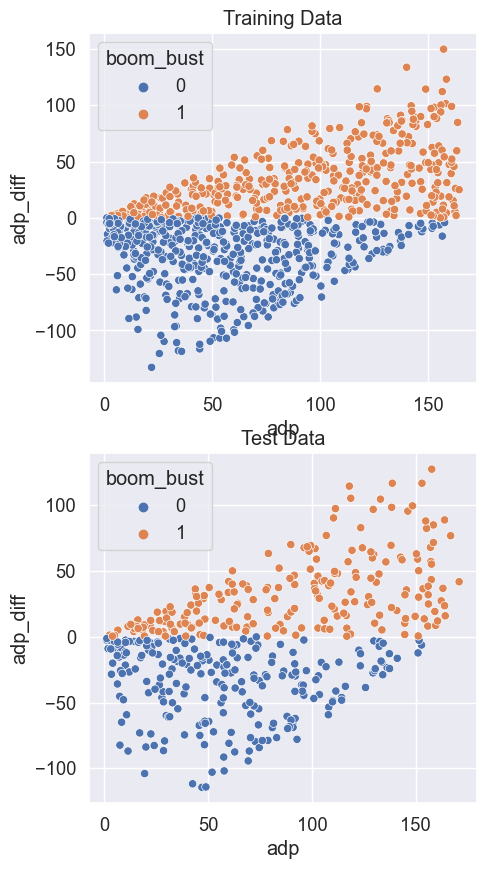

In [28]:
# Create scatter plot of training and test split

print(f' Boom is Positive Number (i.e., Label = 1)')
print(f' Bust is Negative Number (i.e., Label = 0)')

figs, axes = plt.subplots(2,1,figsize=(5, 10))
sns.scatterplot(ax=axes[0],data=df_combined.iloc[ind_train], x='adp', y='adp_diff', hue='boom_bust')
axes[0].set_title('Training Data')
sns.scatterplot(ax=axes[1],data=df_combined.iloc[ind_test], x='adp', y='adp_diff', hue = 'boom_bust')
axes[1].set_title('Test Data')
plt.show()


In [29]:
# Instantiate the MLP model
# model1 = Wide()
# model2 = Deep()


# model = MLP(input_size, hidden_size, output_size)
model = Wide(input_size)

# Initialize the MLP model
init_weights(model)
model.to(device)
print()
print(f" Model structure is {model}")

# Define loss function and optimizer
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=epsilon_torch)
optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay = weight_decay)




 Model structure is Wide(
  (hidden): Linear(in_features=42, out_features=64, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [30]:
# Training loop ========================================================================

accuracies = []
losses = []
auc_test_hold = []
auc_train_hold = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()

    predicted_train = np.array([])
    label_hold_train = np.array([])
    
    for data, labels in train_loader:
        # No need to reshape the data in this case, as they are already flat
        data, labels = data.to(device), labels.to(device)
        
        outputs = model(data)
#         print(f" outputs are {outputs}")
        
        outputs_cpu = outputs.cpu()
        labels_cpu = labels.cpu()
    
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()
        
        losses.append(loss.item())
        
        pred_temp_train = outputs_cpu.detach().numpy()
        label_temp_train = labels_cpu.detach().numpy()

        predicted_train = np.append(predicted_train,pred_temp_train)
        label_hold_train = np.append(label_hold_train,label_temp_train)
            
    fpr, tpr, thresholds = roc_curve(label_hold_train, predicted_train)
    auc_train = auc(fpr, tpr)
    auc_train_hold.append(auc_train)
    
# Calculate accuracy after each epoch
    correct = 0
    total = 0
    predicted = np.array([])
    label_hold = np.array([])
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)

#             print(data.requires_grad)
#             print(labels.requires_grad)

            outputs = model(data)
#             __, predicted = torch.max(outputs.data, 1)
            outputs_cpu = outputs.cpu()
            labels_cpu = labels.cpu()

            pred_temp = outputs_cpu.detach().numpy()
            label_temp = labels_cpu.detach().numpy()

            predicted = np.append(predicted,pred_temp)
            label_hold = np.append(label_hold,label_temp)

         # print(f" predicted values are {predicted}")
        fpr, tpr, thresholds = roc_curve(label_hold, predicted)
        auc_test = auc(fpr, tpr)
        
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
    
        thresh_hold = thresholds[ix] 


    auc_test_hold.append(auc_test)
    
    if (epoch) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            print(f'AUC Train [{auc_train}]')
            print(f'AUC Test [{auc_test}]')
            print()

Epoch [1/2000], Loss: 0.6698
AUC Train [0.49488835082055416]
AUC Test [0.5028157201054397]

Epoch [101/2000], Loss: 0.6956
AUC Train [0.6663609460219628]
AUC Test [0.5671978592539341]

Epoch [201/2000], Loss: 0.7869
AUC Train [0.6842321520287622]
AUC Test [0.5624650531192588]

Epoch [301/2000], Loss: 0.6530
AUC Train [0.6978452808961283]
AUC Test [0.556713795031552]

Epoch [401/2000], Loss: 0.6001
AUC Train [0.7047692420573777]
AUC Test [0.5575924594616184]

Epoch [501/2000], Loss: 0.7541
AUC Train [0.7050602881111355]
AUC Test [0.555016375109833]

Epoch [601/2000], Loss: 0.6345
AUC Train [0.7057499938855871]
AUC Test [0.5583912453071331]

Epoch [701/2000], Loss: 0.6521
AUC Train [0.703247976129332]
AUC Test [0.5534188034188035]

Epoch [801/2000], Loss: 0.7056
AUC Train [0.7052510577934307]
AUC Test [0.5546169821870756]

Epoch [901/2000], Loss: 0.6376
AUC Train [0.7072052241543767]
AUC Test [0.557332854061826]

Epoch [1001/2000], Loss: 0.5372
AUC Train [0.7071025020177563]
AUC Test [0.

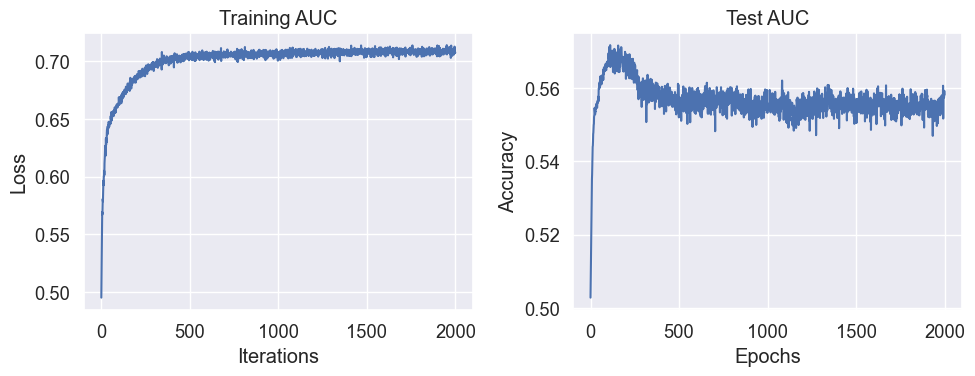

In [31]:


# Plot loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(auc_train_hold)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training AUC')

plt.subplot(1, 2, 2)
plt.plot(auc_test_hold)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test AUC')

plt.tight_layout()
plt.show()

 Boom is Positive Number (i.e., Label = 1)
 Bust is Negative Number (i.e., Label = 0)


/var/folders/3r/69_sw3815tsd6h5_xt98rklh0000gn/T/ipykernel_10284/3106939087.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['prediction'] = np.round(predicted_train)
/var/folders/3r/69_sw3815tsd6h5_xt98rklh0000gn/T/ipykernel_10284/3106939087.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'] = np.round(predicted)


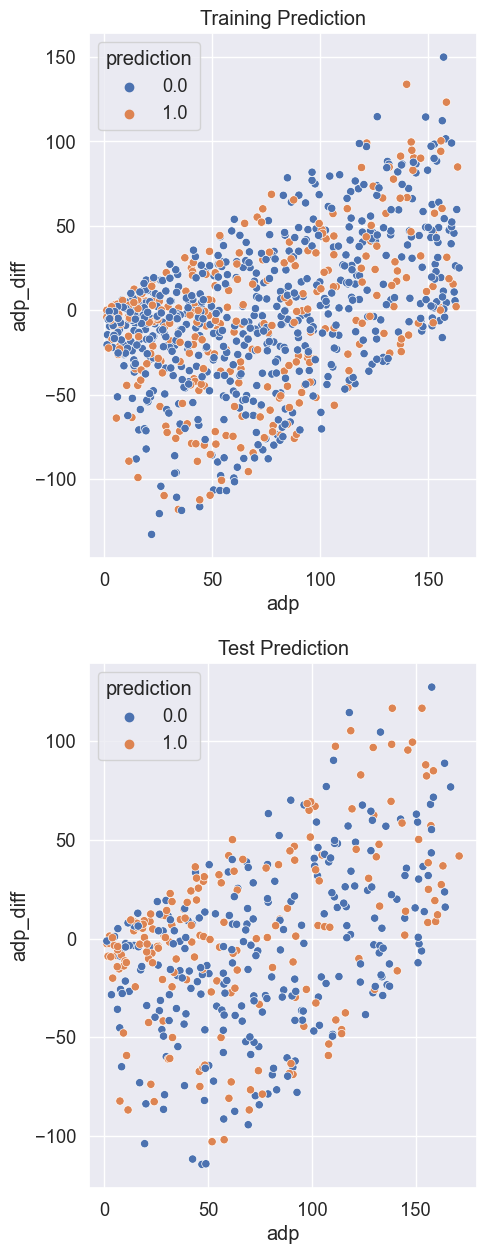

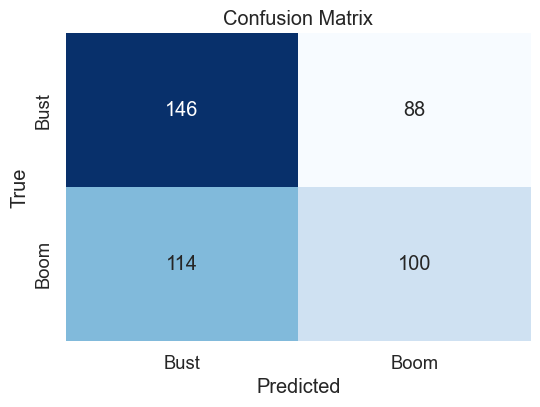

In [32]:
#Want to add test and training predictions to the dataframe

print(f' Boom is Positive Number (i.e., Label = 1)')
print(f' Bust is Negative Number (i.e., Label = 0)')

df_train = df_combined.iloc[ind_train]
df_train['prediction'] = np.round(predicted_train)

df_test = df_combined.iloc[ind_test]
df_test['prediction'] = np.round(predicted)


figs, axes = plt.subplots(2,1,figsize=(5, 15))
sns.scatterplot(ax=axes[0],data=df_train, x='adp', y='adp_diff', hue='prediction')
axes[0].set_title('Training Prediction')
sns.scatterplot(ax=axes[1],data=df_test, x='adp', y='adp_diff', hue = 'prediction')
axes[1].set_title('Test Prediction')
plt.show()


conf_matrix = confusion_matrix(df_test['boom_bust'], df_test['prediction'])

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Bust", "Boom"], yticklabels=["Bust", "Boom"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [33]:
# Run model with current year players
predicted_final = np.array([])                        
with torch.no_grad():
        for data in pred_loader:
            data = data.to(device)
            
            outputs = model(data)

            outputs_cpu = outputs.cpu()

            pred_final_temp = outputs_cpu.detach().numpy()

            predicted_final = np.append(predicted_final,pred_final_temp)

new_arr = np.where(predicted_final > thresh_hold, 1, 0)


df_2023_all['prediction'] = new_arr

df_print = df_2023_all[['name', 'prediction','position']].copy()

print(df_print.to_string())

                         name  prediction position
0            Justin Jefferson           1       WR
1         Christian McCaffrey           0       RB
2               Ja'Marr Chase           0       WR
3                 Tyreek Hill           0       WR
4                 Cooper Kupp           0       WR
5                Travis Kelce           1       TE
6               Austin Ekeler           0       RB
7                Stefon Diggs           0       WR
8              Saquon Barkley           0       RB
9                 CeeDee Lamb           0       WR
10                 A.J. Brown           0       WR
11             Bijan Robinson           0       RB
12              Davante Adams           0       WR
13          Amon-Ra St. Brown           0       WR
14                 Nick Chubb           0       RB
15             Garrett Wilson           0       WR
16               Tony Pollard           0       RB
17              Jaylen Waddle           0       WR
18              Derrick Henry  

In [34]:
# Run model with previous year players to see which type players it got right/wrong
predicted_final = np.array([])                        
with torch.no_grad():
        for data in X2022_loader:
            data = data.to(device)
            
            outputs = model(data)

            outputs_cpu = outputs.cpu()

            pred_final_temp = outputs_cpu.detach().numpy()

            predicted_final = np.append(predicted_final,pred_final_temp)


new_arr = np.where(predicted_final > thresh_hold, 1, 0)

print(f' evalaute model on 2022 data')

df_2022_all['prediction'] = new_arr

df_2022_print = df_2022_all[['name', 'boom_bust','prediction','position']].copy()

print(df_2022_print.to_string())

 evalaute model on 2022 data
                         name  boom_bust  prediction position
196           Jonathan Taylor          0           0       RB
197       Christian McCaffrey          1           0       RB
198             Austin Ekeler          0           0       RB
199             Derrick Henry          0           0       RB
200          Justin Jefferson          1           1       WR
201               Cooper Kupp          1           0       WR
202              Najee Harris          0           0       RB
203               Dalvin Cook          0           1       RB
204             Ja'Marr Chase          1           0       WR
205                 Joe Mixon          0           0       RB
206              Alvin Kamara          0           0       RB
207             Davante Adams          0           0       WR
208             D'Andre Swift          0           0       RB
209              Stefon Diggs          1           0       WR
210               Aaron Jones          0 